In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import h3
import geopandas as gpd
import geojson

In [3]:
import sys
print(sys.path)

['C:\\Users\\marlxn\\Desktop\\uni\\master\\AAA\\AAA-AIbertus-Magnus\\tasks', 'C:\\Users\\marlxn\\miniconda3\\python312.zip', 'C:\\Users\\marlxn\\miniconda3\\DLLs', 'C:\\Users\\marlxn\\miniconda3\\Lib', 'C:\\Users\\marlxn\\miniconda3', '', 'C:\\Users\\marlxn\\miniconda3\\Lib\\site-packages', 'C:\\Users\\marlxn\\miniconda3\\Lib\\site-packages\\win32', 'C:\\Users\\marlxn\\miniconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\marlxn\\miniconda3\\Lib\\site-packages\\Pythonwin']


In [4]:
df = pd.read_csv("../data/analytics_trip_data.csv", nrows=1000000)

In [5]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

In [6]:
df["trip_middle_timestamp"] = df["trip_start_timestamp"] + ((df['trip_end_timestamp']-df['trip_start_timestamp'])/2)

In [22]:
df = df[(df["fare"] != 0) & (df["trip_miles"] != 0)]

In [23]:
df["price_per_mile"] = df["fare"]/df["trip_miles"]

In [24]:
df.rename(columns={"h3_res_4": "h3_res_4_pickup", "h3_res_6": "h3_res_6_pickup", "h3_res_8":"h3_res_8_pickup"},inplace=True)

In [25]:
pd.set_option('display.max_columns', None)
df.describe()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,temperature,precipitation,trip_middle_timestamp,price_per_mile
count,888598,888598,888573.000000,888563.000000,6.458540e+05,6.458540e+05,888540.000000,886193.000000,888556.000000,888556.000000,651844.000000,888556.000000,888556.000000,888598.000000,888598.000000,888598,888553.000000
mean,2018-01-12 15:19:12.252762624,2018-01-12 15:31:39.930002176,739.132734,3.425349,1.703140e+10,1.703136e+10,24.583767,21.488661,12.425146,1.575781,0.000945,0.699536,14.826253,-3.776841,0.001056,2018-01-12 15:25:26.091382016,8.066875
min,2018-01-01 00:15:00,2018-01-01 00:15:00,0.000000,0.010000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.010000,-22.777778,0.000000,2018-01-01 00:15:00,0.000192
25%,2018-01-07 03:30:00,2018-01-07 03:45:00,336.000000,0.800000,1.703108e+10,1.703108e+10,8.000000,8.000000,6.000000,0.000000,0.000000,0.000000,7.000000,-10.555556,0.000000,2018-01-07 03:37:30,3.700000
50%,2018-01-12 15:45:00,2018-01-12 16:00:00,532.000000,1.400000,1.703128e+10,1.703128e+10,28.000000,23.000000,7.750000,0.000000,0.000000,0.000000,9.500000,-5.555556,0.000000,2018-01-12 15:52:30,5.333333
75%,2018-01-18 07:15:00,2018-01-18 07:30:00,855.000000,3.200000,1.703184e+10,1.703183e+10,32.000000,32.000000,12.500000,2.000000,0.000000,1.000000,14.700000,3.333333,0.000000,2018-01-18 07:22:30,7.187500
max,2018-01-22 22:00:00,2018-02-06 15:15:00,84325.000000,783.700000,1.703198e+10,1.703198e+10,77.000000,77.000000,6001.200000,162.750000,75.000000,1414.120000,6001.200000,15.555556,0.200000,2018-01-29 12:45:00,60012.000000
std,NaN,NaN,1018.683749,4.986247,3.416184e+05,3.263849e+05,19.242601,16.569738,15.691607,2.574751,0.213567,2.169715,17.791240,9.109969,0.014107,NaN,86.072153


In [8]:
#Pass dataframe as pd object and h3geocol,datacol,legend_name as strings
def create_choropleth(dataframe,h3geocol,datacol,legend_name):
    grouped_data = dataframe.groupby(dataframe[h3geocol])[datacol].mean().reset_index()
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
    
    geojson_data = {
        'type': 'FeatureCollection',
        'features': []
    }
    
    for index, row in grouped_data.iterrows():
        geometry = {'type': 'Polygon', 'coordinates': [h3.h3_to_geo_boundary(row[h3geocol], geo_json=True)]}
        feature = {'type': 'Feature', 'geometry': geometry, 'properties': {f'{h3geocol}': row[h3geocol],f'{datacol}': row[datacol]}}
        geojson_data['features'].append(feature)
        
    cp = folium.Choropleth(
        geo_data=geojson_data,
        data=grouped_data,
        columns=[h3geocol, datacol],
        key_on=f'feature.properties.{h3geocol}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)

    folium.GeoJsonTooltip([h3geocol,datacol]).add_to(cp.geojson)
    
    return m

In [9]:
create_choropleth(df,"h3_res_8_dropoff","trip_seconds","Average Total trip seconds")

In [10]:
create_choropleth(df,"h3_res_8_pickup","trip_total","Average total trip price")

In [21]:
create_choropleth(df,"h3_res_8_pickup","tips","Average tips")

In [12]:
census_tract_geojson =  gpd.read_file("../data/Chicago_boundaries.geojson")

In [13]:
census_tract_geojson

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ..."
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ..."
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ..."
...,...,...,...,...,...,...,...,...,...,...
796,17,704,7,Census Tract 704,7,17031070400,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ..."
797,17,705,7,Census Tract 705,7,17031070500,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ..."
798,17,1303,13,Census Tract 1303,13,17031130300,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ..."
799,17,2922,29,Census Tract 2922,29,17031292200,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ..."


In [27]:
tempdf = df

In [28]:
hourly = tempdf.groupby(df["trip_middle_timestamp"].dt.hour)["trip_seconds"].mean().reset_index()
weekdaily = tempdf.groupby(df["trip_middle_timestamp"].dt.weekday)["trip_seconds"].mean().reset_index()

In [29]:
# Neue Spalten für Stunde und Wochentag hinzufügen
tempdf['hour'] = df['trip_middle_timestamp'].dt.hour
tempdf['weekday'] = df['trip_middle_timestamp'].dt.day_name()

<Axes: xlabel='hour', ylabel='weekday'>

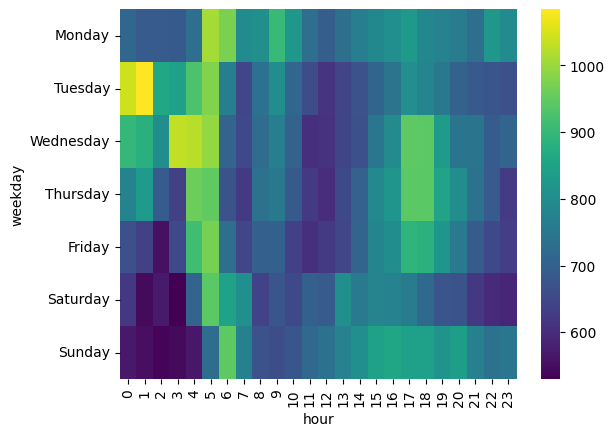

In [30]:
pivot_table_trip_seconds = tempdf.pivot_table(index='weekday', columns='hour', values='trip_seconds', aggfunc='mean')
pivot_table_trip_seconds = pivot_table_trip_seconds.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_trip_seconds, cmap='viridis') #trip seconds

<Axes: xlabel='hour', ylabel='weekday'>

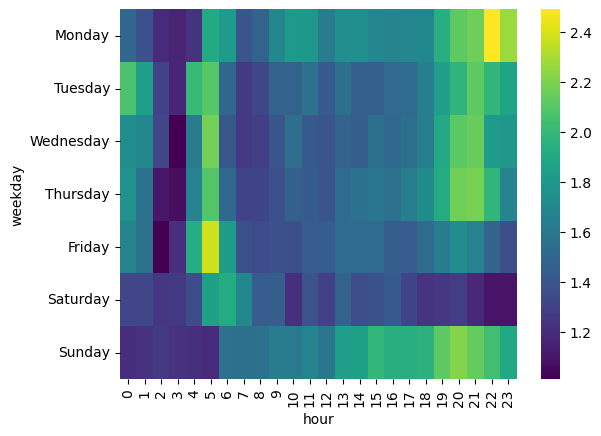

In [31]:
pivot_table_count = tempdf.pivot_table(index='weekday', columns='hour',values="tips",aggfunc='mean')
pivot_table_count = pivot_table_count.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_count, cmap='viridis') #trip count

<Axes: xlabel='hour', ylabel='weekday'>

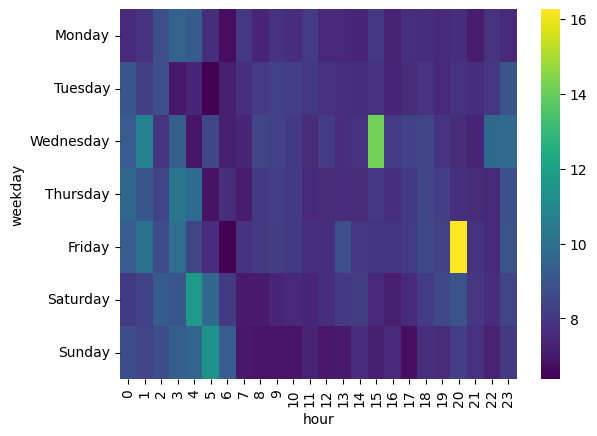

In [32]:
pivot_table_count = tempdf.pivot_table(index='weekday', columns='hour',values="price_per_mile",aggfunc='mean')
pivot_table_count = pivot_table_count.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_count, cmap='viridis') #trip count